In [1]:
import sys
import pickle
sys.path.append("../../courses/machine-learning/ud120-projects/tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import pandas as pd
import pandasql as sql
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Task 1: Select what features you'll use.
`features_list` is a list of strings, each of which is a feature name. The first feature must be "poi".

In [2]:
features_list = ['poi','salary', "total_earned_cash_value", 
                "exercised_stock_options"] # You will need to use more features

In [3]:
# Load dict containing dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [4]:
### Two oddities to be dealt with. Robert Belfer's data is incorrectly
### input, as is Sanjay Bhatnagar's.
data_dict["BELFER ROBERT"]["deferred_income"] = -102500
data_dict["BELFER ROBERT"]["deferral_payments"] = 0
data_dict["BELFER ROBERT"]["total_payments"] = 3285
data_dict["BELFER ROBERT"]["exercised_stock_options"] = 0
data_dict["BELFER ROBERT"]["restricted_stock"] = 44093
data_dict["BELFER ROBERT"]["restricted_stock_deferred"] = -44093
data_dict["BELFER ROBERT"]["total_stock_value"] = 0
data_dict["BELFER ROBERT"]["expenses"] = 3285
data_dict["BELFER ROBERT"]["director_fees"] = 102500

data_dict["BHATNAGAR SANJAY"]["expenses"] = 137864
data_dict["BHATNAGAR SANJAY"]["total_payments"] = 137864
data_dict["BHATNAGAR SANJAY"]["total_stock_value"] = 15456290
data_dict["BHATNAGAR SANJAY"]["exercised_stock_options"] = 15456290
data_dict["BHATNAGAR SANJAY"]["restricted_stock"] = 2604490
data_dict["BHATNAGAR SANJAY"]["restricted_stock_deferred"] = -2604490
data_dict["BHATNAGAR SANJAY"]["other"] = 0
data_dict["BHATNAGAR SANJAY"]["director_fees"] = 0

In [5]:
## transform to pandas DF for ease of use
data_df = pd.DataFrame.from_dict(data_dict, orient="index")
data_df.replace("NaN", 0, inplace=True)
data_df.poi = data_df.poi.astype(bool)
data_df.email_address = data_df.email_address.astype("str")
data_df["employee"] = data_df.index

In [6]:
data_df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person,employee
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,2195,152,65,False,0,-3081055,304805,phillip.allen@enron.com,47,ALLEN PHILLIP K
BADUM JAMES P,0,0,178980,182466,257817,0,0,0,0,257817,...,0,0,0,False,0,0,0,0,0,BADUM JAMES P
BANNANTINE JAMES M,477,566,0,916197,4046157,0,1757552,465,-560222,5243487,...,29,864523,0,False,0,-5104,0,james.bannantine@enron.com,39,BANNANTINE JAMES M
BAXTER JOHN C,267102,0,1295738,5634343,6680544,1200000,3942714,0,0,10623258,...,0,2660303,0,False,0,-1386055,1586055,0,0,BAXTER JOHN C
BAY FRANKLIN R,239671,0,260455,827696,0,400000,145796,0,-82782,63014,...,0,69,0,False,0,-201641,0,frank.bay@enron.com,0,BAY FRANKLIN R


Let's just look at everything

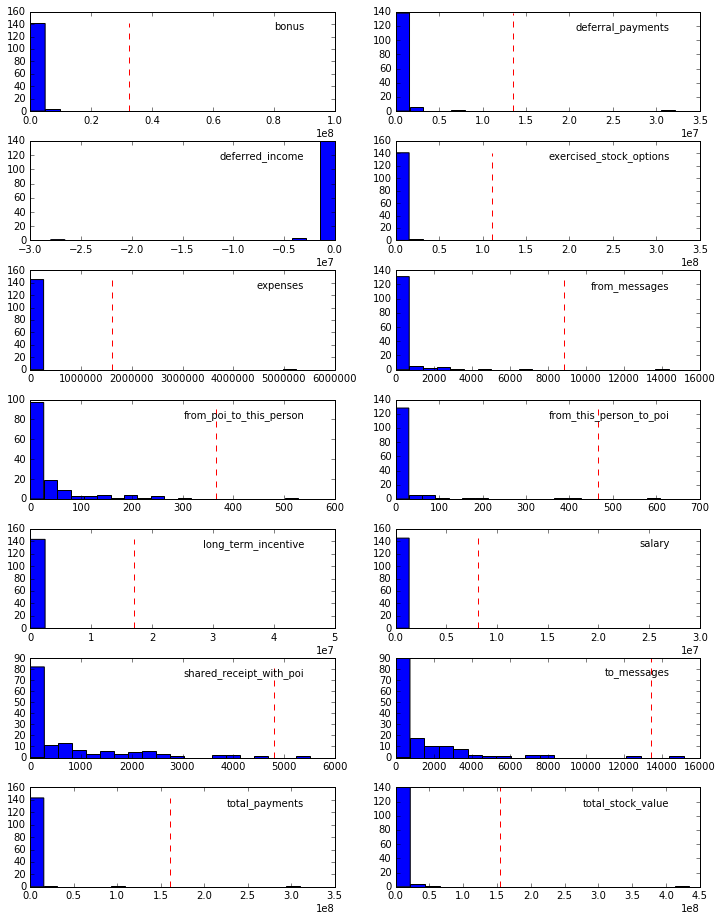

In [7]:
features_list = ["bonus", "deferral_payments", "deferred_income", 
                 "exercised_stock_options", "expenses", "from_messages", 
                 "from_poi_to_this_person", "from_this_person_to_poi", 
                 "long_term_incentive", "salary", "shared_receipt_with_poi",
                 "to_messages", "total_payments", "total_stock_value"]

def many_histograms(the_data, features_list, log=True, pct=0.995):
    fig = plt.figure(figsize=(12,18))
    fig.subplots_adjust(hspace=0.3)
    for ii in range(len(features_list)):
        ax = plt.subplot(len(features_list)/2 + 1, 2, ii+1)
        ax.hist(list(the_data[features_list[ii]]), bins=20)
        H, dum = np.histogram(list(the_data[features_list[ii]]), bins=20)
        ax.plot([the_data[features_list[ii]].quantile(pct), the_data[features_list[ii]].quantile(pct)], 
                [0, max(H)], linestyle="--", color="r")
        ax.text(0.9, 0.9, features_list[ii], transform = ax.transAxes, 
                horizontalalignment="right", verticalalignment="top")

        
    plt.show()
    
many_histograms(data_df, features_list)

**These have outliers that should be removed**
- Total payments
- Total stock value
- Long term incentive
- Salary
- From this person to POI
- From POI to this person
- From messages
- Exercised stock options
- Bonus
- Deferral payments

### Task 2: Remove outliers
The first range of outliers would be employees with no
reported salary, no reported total payments, and no total stock value.
I expect my POI classifier will rely on at least one of these (or one of
the components that will contribute to one of the totals), so if all of
these are null (in this case a zero), then they're just not useful

In [8]:
the_query = "SELECT *"
the_query += " FROM data_df"
the_query += " WHERE total_payments!=0"
no_null_df = sql.sqldf(the_query, locals())

In [9]:
the_query = "SELECT *"
the_query += " FROM data_df"
the_query += " WHERE total_payments = 0"
sql.sqldf(the_query, locals())

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person,employee
0,0,0,0,0,0,0,32460,0,-32460,0,...,0,0,0,0,98784,-98784,0,0,0,CHAN RONNIE
1,0,0,0,0,5127155,0,950730,0,0,6077885,...,0,0,0,0,0,0,0,diomedes.christodoulou@enron.com,0,CHRISTODOULOU DIOMEDES
2,0,0,0,0,0,0,662086,0,-472568,189518,...,0,0,0,0,0,0,0,0,0,CLINE KENNETH W
3,0,764,0,0,651850,0,386335,58,0,1038185,...,12,0,0,0,0,0,0,bill.cordes@enron.com,10,CORDES WILLIAM R
4,0,517,0,0,1324578,0,560170,10,0,1884748,...,36,0,0,0,0,0,0,kulvinder.fowler@enron.com,0,FOWLER PEGGY
5,0,0,0,0,1753766,0,264013,0,-72419,1945360,...,0,0,0,0,0,0,0,0,0,GATHMANN WILLIAM D
6,0,0,0,0,9803,0,75838,0,0,85641,...,0,0,0,0,0,0,0,0,0,GILLIS JOHN
7,0,2649,0,0,0,0,346663,571,0,346663,...,1061,0,38,0,0,0,0,rod.hayslett@enron.com,35,HAYSLETT RODERICK J
8,0,719,0,0,754966,0,363428,589,0,1118394,...,34,0,5,0,0,0,0,james.hughes@enron.com,35,HUGHES JAMES A
9,0,952,0,0,850477,0,0,739,0,850477,...,26,0,0,0,0,0,0,richard.lewis@enron.com,10,LEWIS RICHARD


Let's take another look at everything, with some pruning done

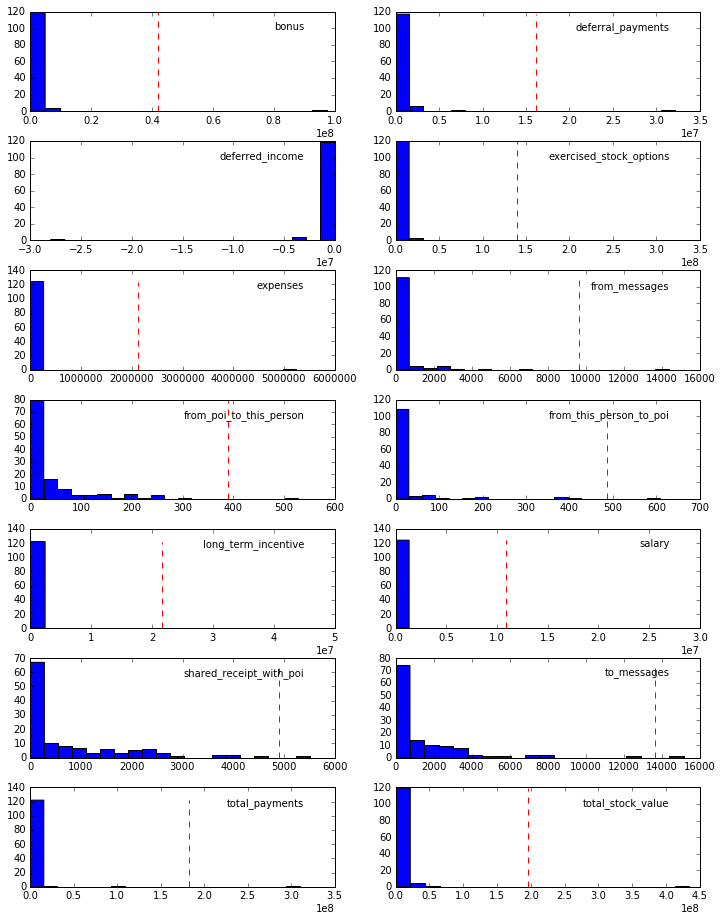

In [10]:
many_histograms(no_null_df, features_list)

### Outlier identification round 2
**These still have high-end outliers to be removed by the 3-$\sigma$ cut**
- Total payments
- Total stock value
- Long term incentive
- Salary
- From this person to POI
- From POI to this person
- From messages
- Exercised stock options
- Bonus
- Deferral payments

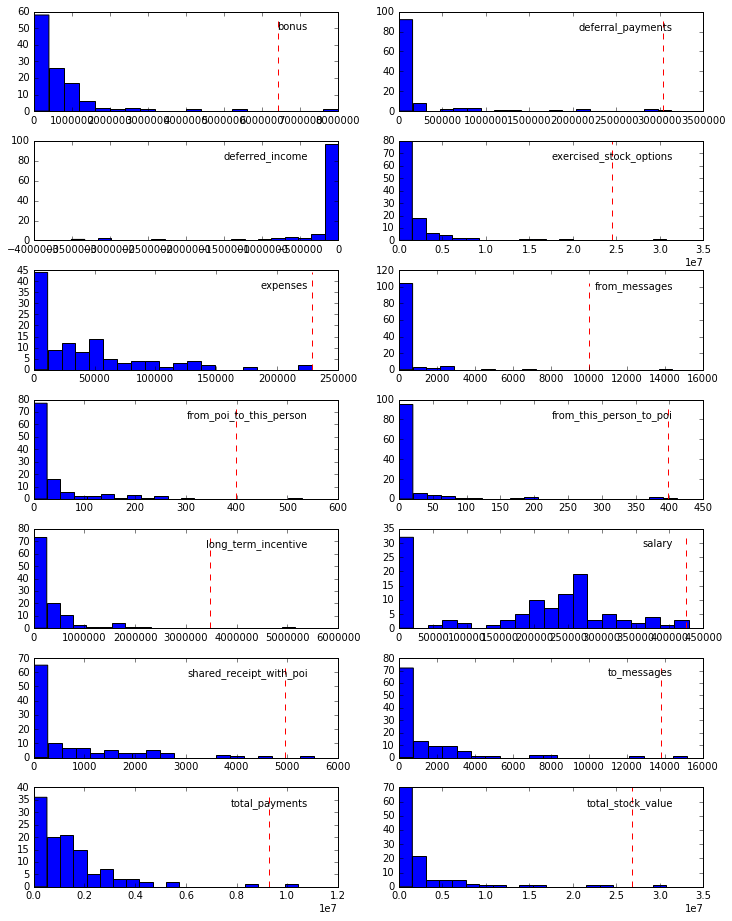

In [11]:
three_sig_cut = (data_df.bonus < data_df.bonus.quantile(0.995)) & \
    (data_df.salary < data_df.salary.quantile(0.95)) &\
    (data_df.from_this_person_to_poi < data_df.from_this_person_to_poi.quantile(0.995)) &\
    (data_df.long_term_incentive < data_df.long_term_incentive.quantile(0.995)) &\
    (data_df.total_stock_value < data_df.total_stock_value.quantile(0.995)) &\
    (data_df.total_payments > 0)

no_outliers = data_df[three_sig_cut]
many_histograms(no_outliers, features_list)

I think we've done enough pruning. Let's try a logarithmic re-scaling

In [12]:
def single_histo(data, feature):
    fig = plt.figure(figsize=(8, 3))
    ax = plt.subplot(111)
    ax.hist(np.log10(data[feature] + 1), bins=20)
    ax.text(0.95, 0.9, feature, transform=ax.transAxes, horizontalalignment="right")
    plt.show()

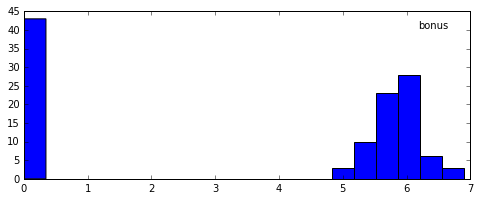

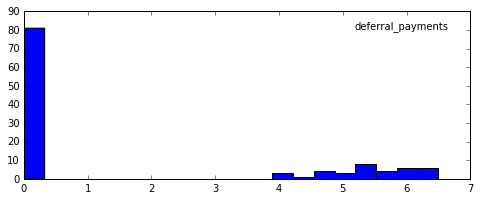

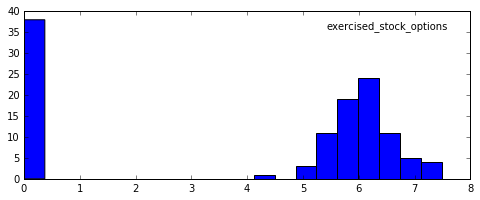

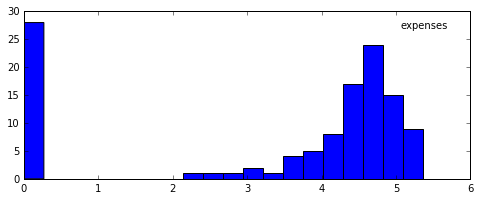

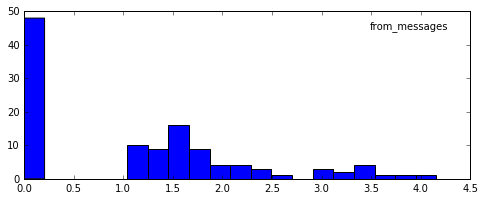

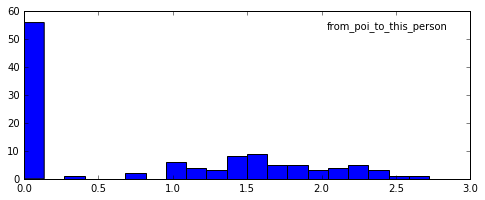

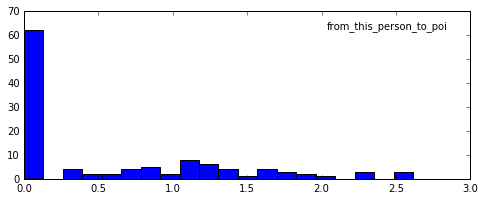

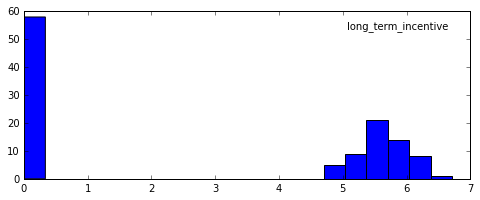

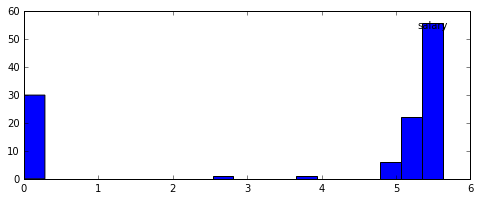

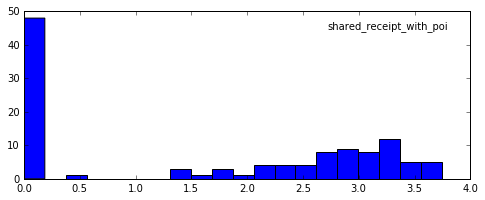

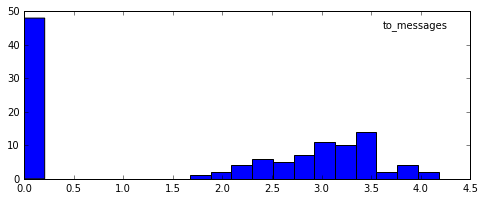

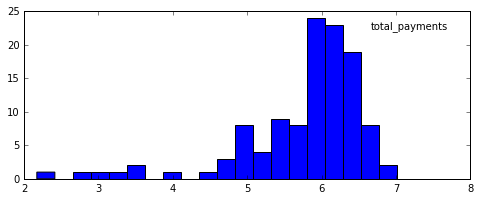

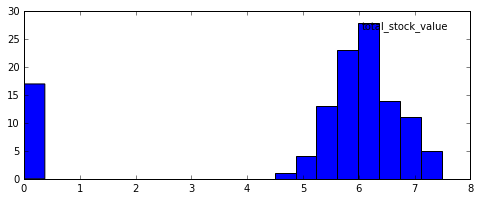

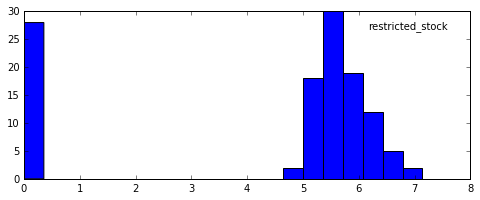

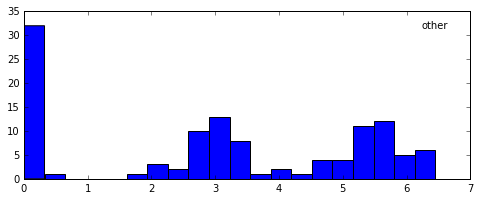

In [13]:
these_feats = ["bonus", "deferral_payments",
                 "exercised_stock_options", "expenses", "from_messages", 
                 "from_poi_to_this_person", "from_this_person_to_poi", 
                 "long_term_incentive", "salary", "shared_receipt_with_poi",
                 "to_messages", "total_payments", "total_stock_value",
              "restricted_stock", "other"]

for feat in these_feats:
    single_histo(no_outliers, feat)

**If used, log-scale these**
- bonus
- exercised_stock_options
- expenses
- long_term_incentive
- salary
- shared_receipt_with_poi (maybe)
- to_messages
- total_payments
- total_stock_value
- restricted_stock
- other

Lastly, check which features are actually used by the persons of interest. No good training a classifier on features that don't describe persons of interest

In [14]:
the_query = "SELECT employee FROM no_null_df"
the_query += " WHERE employee NOT IN ("
the_query += " SELECT employee FROM no_outliers)"
sql.sqldf(the_query, locals())

,employee
0,DELAINEY DAVID W
1,DERRICK JR. JAMES V
2,FASTOW ANDREW S
3,FREVERT MARK A
4,LAY KENNETH L
5,PICKERING MARK R
6,SKILLING JEFFREY K
7,TOTAL
8,WHALLEY LAWRENCE G


In [15]:
len(no_outliers)

116

In [16]:
the_query = "SELECT salary, to_messages, bonus, total_payments"
the_query += " FROM no_outliers"
the_query += " WHERE poi = 1"
sql.sqldf(the_query, locals())

,salary,to_messages,bonus,total_payments
0,213999,7991,5249999,5501630
1,278601,1858,1350000,2669589
2,240189,2598,1250000,1639297
3,415189,1892,1000000,1868758
4,288542,1758,1200000,1490344
5,274975,873,600000,1272284
6,243293,1045,1500000,288682
7,0,0,0,91093
8,309946,2374,700000,1587421
9,224305,0,800000,2652612


These are the columns where at *most* 3 of remaining POI (21.4%) are missing data,
and thus will be our feature list moving forward:
- salary (log) | 1 missing
- to_messages (log) | 3 missing
- total_payments (log) | 0 missing
- bonus (log) | 2 missing
- restricted_stock (log) | 1 missing
- shared_receipt_with_poi | 3 missing
- total_stock_value (log) | 0 missing
- from_messages | 3 missing
- other (log) | 0 missing
- from_this_person_to_poi | 3 missing
- from_poi_to_this_person | 3 missing
- expenses (log) | 0 missing

Initial pruning done. Let's look at everything vs everything

In [17]:
def megaplot(the_data, features):
    indx = 1
    poi = the_data.poi == True

    fig = plt.figure(figsize=(18,18))

    for ii in range(len(features)):
        for jj in range(len(features)):
            if ii != jj:
                ax = plt.subplot(len(features), len(features) - 1, indx)
                x = the_data[features[jj]]
                y = the_data[features[ii]]
                    
                ax.scatter(list(x[~poi]), 
                           list(y[~poi]), 
                           c="b", s=10, edgecolor="None")
                
                ax.scatter(list(x[poi]), 
                           list(y[poi]), 
                           c="r", s=10, edgecolor="None")
                
                ax.set_xticklabels([])
#                 ax.set_ylim([min(y), max(y)])
#                 ax.set_yticklabels([])
                if (jj == 0) or ((jj == 1) & (ii == 0)):
                    ax.set_ylabel(features[ii])
                    
                indx += 1
    plt.show()

In [18]:
no_outliers["log_salary"] = np.log10(no_outliers.salary + 1)
no_outliers["log_to_messages"] = np.log10(no_outliers.to_messages + 1)
no_outliers["log_total_payments"] = np.log10(no_outliers.total_payments + 1)
no_outliers["log_bonus"] = np.log10(no_outliers.bonus + 1)
no_outliers["log_restricted_stock"] = np.log10(no_outliers.restricted_stock + 1)
no_outliers["log_total_stock_value"] = np.log10(no_outliers.total_stock_value + 1)
no_outliers["log_other"] = np.log10(no_outliers.other + 1)
no_outliers["log_long_term_incentive"] = np.log10(no_outliers.long_term_incentive + 1)
no_outliers["log_expenses"] = np.log10(no_outliers.expenses + 1)

/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

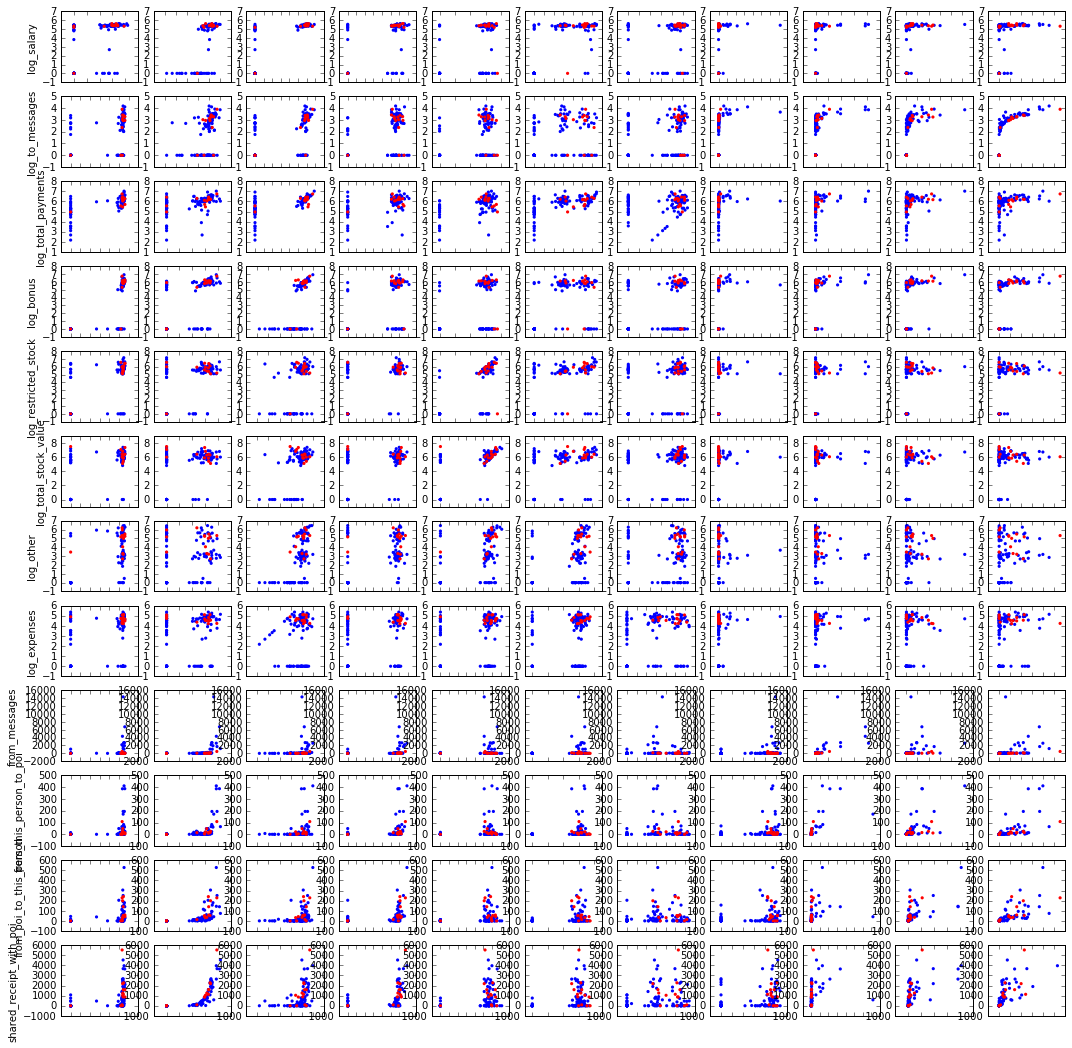

In [19]:
features_list = ["log_salary", "log_to_messages", "log_total_payments", "log_bonus",
                "log_restricted_stock", "log_total_stock_value", "log_other",
                "log_expenses", "from_messages",
                "from_this_person_to_poi", "from_poi_to_this_person", "shared_receipt_with_poi"]
# features_list = ["log_salary", 
#                 "log_restricted_stock", "log_other",
#                 "log_expenses"]

megaplot(no_outliers, features_list)

### Task 3: Create new feature(s)

A new feature: `stocks_cash_ratio`

In [20]:
new_col = "stocks_cash_ratio"
no_outliers[new_col] = no_outliers.total_stock_value / no_outliers.total_payments
# no_outliers[new_col] = no_outliers[new_col].replace(np.inf, 1E12)

/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


New features: `total_emails`, `fractions_sent`, `fractions_received`

In [21]:
no_outliers["total_emails"] = no_outliers[["from_messages", "to_messages"]].sum(axis=1)
no_outliers["fractions_sent"] = no_outliers.from_messages / no_outliers.total_emails.astype(float)
no_outliers["fractions_received"] = no_outliers.to_messages / no_outliers.total_emails.astype(float)

/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [22]:
my_data = no_outliers.fillna(0).to_dict(orient="index")

for key in my_data:
    the_name = my_data[key]["employee"]
    my_data[the_name] = my_data.pop(key)

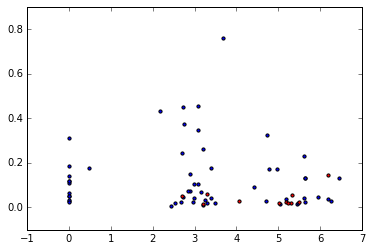

In [23]:
poi = no_outliers.poi == True
plt.scatter(no_outliers[~poi].log_other, 
            no_outliers[~poi].fractions_sent, c='b', s=10)
plt.scatter(no_outliers[poi].log_other, 
            no_outliers[poi].fractions_sent, c='r', s=10)
# plt.xlim(0,10)
# plt.ylim(3, 6.0)
plt.show()

### Extract features and labels from dataset for local testing
Rewriting this so that it works with my dataframe

In [24]:
features_list = ["poi", "log_other", "stocks_cash_ratio", "fractions_sent", "log_expenses"]
# features_list = ["poi", "log_other", "log_expenses"]
data = featureFormat(my_data, features_list, sort_keys=True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a Variety of Classifiers
Please name your classifier clf for easy export below.
Note that if you want to do PCA or other multi-stage operations,
you'll need to use Pipelines. For more info:
http://scikit-learn.org/stable/modules/pipeline.html


In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans, FeatureAgglomeration
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,\
    BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.mixture import GMM

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import train_test_split, KFold

In [26]:
def evaluate_classifiers(classifier_dict, features, labels, iters=50, 
                         prec_avg=None, plot=False, outfile=None):
   
    np.random.seed(42)
    
    if plot:
        fig = plt.figure(figsize=(10,10))
        ax1 = plt.subplot(311)
        ax2 = plt.subplot(312)
        ax3 = plt.subplot(313)
        
    for classifier in classifier_dict.keys():
        clf = classifier_dict[classifier]
        acc_scores = np.zeros(iters)
        prec_scores = np.zeros(iters)
        recall_scores = np.zeros(iters)
        

        for ii in range(iters):
            X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                            test_size=0.4)

            clf.fit(X_train, y_train)
            pred = clf.predict(X_test)
            acc_scores[ii] = accuracy_score(y_test, pred)

            if prec_avg:
                prec_scores[ii] = precision_score(y_test, pred, average=prec_avg)
                recall_scores[ii] = recall_score(y_test, pred, average=prec_avg)

            else:
                prec_scores[ii] = precision_score(y_test, pred)
                recall_scores[ii] = recall_score(y_test, pred)
              

        if plot:
            ax1.plot(acc_scores,
                     label=classifier + ": %.3f $\pm$ %.3f" % (acc_scores.mean(),
                                                               acc_scores.std()))
            ax2.plot(prec_scores,
                     label=classifier + ": %.3f $\pm$ %.3f" % (prec_scores.mean(),
                                                               prec_scores.std()))
            ax3.plot(recall_scores,
                     label=classifier + ": %.3f $\pm$ %.3f" % (recall_scores.mean(),
                                                               recall_scores.std()))
            
        else:
            print "%s: " % classifier
            print "\tAccuracy - %.6f (%.6f, %.6f, %.6f)" % (acc_scores.mean(),
                                                        min(acc_scores),
                                                            np.median(acc_scores),
                                                        max(acc_scores))

            print "\tPrecision - %.6f (%.6f, %.6f, %.6f)" % (prec_scores.mean(),
                                                         min(prec_scores),
                                                             np.median(prec_scores),
                                                         max(prec_scores))

            print "\tRecall - %.6f (%.6f, %.6f, %.6f)\n" % (recall_scores.mean(),
                                                        min(recall_scores),
                                                            np.median(recall_scores),
                                                        max(recall_scores))
    
    if plot:
        ax1.set_ylabel("Accuracy Score")
        ax2.set_ylabel("Precision Score")
        ax3.set_ylabel("Recall Score")
        ax1.set_ylim(0, 1.5)
        ax2.set_ylim(0, 1.5)
        ax3.set_ylim(0, 1.5)
        ax1.minorticks_on()
        ax2.minorticks_on()
        ax3.minorticks_on()
        ax1.legend(fontsize=10)
        ax2.legend(fontsize=10)
        ax3.legend(fontsize=10)
        if outfile:
            plt.savefig(outfile)
        plt.show()

In [27]:
classifiers = {"GaussianNB" : GaussianNB(), 
               "Decision Tree" : DecisionTreeClassifier(random_state=5),
               "KNearest" : KNeighborsClassifier(),
               "SVC - rbf" : SVC(kernel="rbf"),
               "LinearSVC" : LinearSVC(),
               "KMeans" : KMeans(random_state=5, n_clusters=2),
               "RandomForestClassifier" : RandomForestClassifier(),
               "RandomForestClassifier - entropy" : RandomForestClassifier(criterion='entropy'),
               "AdaBoostClassifier" : AdaBoostClassifier(),
               "BaggingClassifier" : BaggingClassifier(),
               "ExtraTreesClassifier" : ExtraTreesClassifier(),
               "GradientBoostingClassifier" : GradientBoostingClassifier(),
               "RidgeClassifier" : RidgeClassifier()}

evaluate_classifiers(classifiers, features, labels)

GaussianNB: 
	Accuracy - 0.694783 (0.500000, 0.673913, 0.869565)
	Precision - 0.238839 (0.000000, 0.215839, 0.500000)
	Recall - 0.605135 (0.000000, 0.645833, 1.000000)

ExtraTreesClassifier: 
	Accuracy - 0.856522 (0.782609, 0.847826, 0.934783)
	Precision - 0.307286 (0.000000, 0.333333, 1.000000)
	Recall - 0.148198 (0.000000, 0.154762, 0.500000)

RandomForestClassifier - entropy: 
	Accuracy - 0.872609 (0.804348, 0.869565, 0.978261)
	Precision - 0.294905 (0.000000, 0.154762, 1.000000)
	Recall - 0.142952 (0.000000, 0.125000, 0.750000)

AdaBoostClassifier: 
	Accuracy - 0.851304 (0.717391, 0.858696, 0.956522)
	Precision - 0.381446 (0.000000, 0.333333, 1.000000)
	Recall - 0.252667 (0.000000, 0.200000, 0.750000)

KMeans: 
	Accuracy - 0.848261 (0.152174, 0.891304, 0.956522)
	Precision - 0.053182 (0.000000, 0.000000, 0.500000)
	Recall - 0.058556 (0.000000, 0.000000, 1.000000)

BaggingClassifier: 
	Accuracy - 0.846957 (0.739130, 0.847826, 0.956522)
	Precision - 0.224079 (0.000000, 0.126984, 1.00

/Users/Nick/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


- **DecisionTree** is a definite maybe
- **ExtraTreesClassifier** is a maybe
- **RandomForestClassifier** is a maybe with criterion = 'entropy'
- **AdaBoostClassifier** is a maybe
- **GradientBoostingClassifier** is a maybe
- **LinearSVC** is a maybe
- BaggingClassifier is out
- GaussianNB is close but not tuneable
- KMeans is out
- RidgeClassifier is out
- KNearest is out
- SVC is out

In [28]:
def plot_precision_recall_param(precision, recall, param, param_name):
    fig = plt.figure(figsize=(8, 3))
    ax = plt.subplot(111)
    ax.plot(param, precision, color="b", label="precision")
    ax.scatter(param[precision.argmax()], precision[precision.argmax()] + 0.01, marker="v", c="r")
    ax.text(0.02, 0.9, "Precision Max: %.3f at %s: %g" % (precision.max(), 
                                                          param_name, 
                                                          param[precision.argmax()]),
           horizontalalignment="left", verticalalignment="top", transform=ax.transAxes)
    
    ax.plot(param, recall, color="g", label="recall")
    ax.scatter(param[recall.argmax()], recall[recall.argmax()] + 0.01, marker="v", c="k")
    ax.text(0.02, 0.8, "Recall Max: %.3f at %s: %g" % (recall.max(), 
                                                          param_name, 
                                                          param[recall.argmax()]),
           horizontalalignment="left", verticalalignment="top", transform=ax.transAxes)
    
    ax.set_xlabel(param_name)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Score")
    ax.minorticks_on()
    ax.legend()
    plt.show()

### Task 5: Tune your classifier to achieve better than .3 precision and recall using our testing script.

In [29]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size = 0.4, random_state = 42)
data = {"x_train" : x_train, "y_train" : y_train, "x_test" : x_test, 
        "y_test" : y_test}

classifiers = {}

#### Tuning ExtraTrees

In [30]:
est_array = np.arange(1, 100)
prec = np.zeros(len(est_array))
rec = np.zeros(len(est_array))

for ii in range(len(est_array)):
    clf = ExtraTreesClassifier(n_estimators=est_array[ii], random_state=5)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")
   

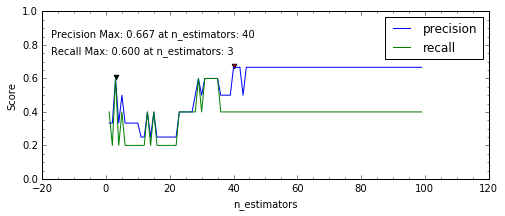

In [31]:
plot_precision_recall_param(prec, rec, est_array, "n_estimators")

`n_estimators` = 32

In [32]:
clf = ExtraTreesClassifier(criterion="entropy", n_estimators=32, random_state=5)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")

Precision Score: 0.500
Recall Score: 0.400


In [33]:
clf = ExtraTreesClassifier(criterion="gini", n_estimators=32, random_state=5)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")

Precision Score: 0.600
Recall Score: 0.600


default

In [34]:
feats = np.arange(1, len(features_list))
prec = np.zeros(len(feats))
rec = np.zeros(len(feats))

for ii in range(len(feats)):
    clf = ExtraTreesClassifier(n_estimators=32, max_features=feats[ii],
                               random_state=5)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")
   

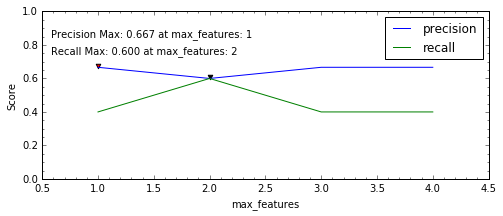

In [35]:
plot_precision_recall_param(prec, rec, feats, "max_features")

max_features=2

The other values are tree-specific, so they will stay as is. We shall use 14 estimators with the "entropy" criterion

In [36]:
classifiers["ExtraTreesClassifier"] = ExtraTreesClassifier(n_estimators=32, max_features=2)

#### Tuning DecisionTreeClassifier

In [37]:
clf = DecisionTreeClassifier(criterion="gini", random_state=5)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")


Precision Score: 0.143
Recall Score: 0.200


In [38]:
clf = DecisionTreeClassifier(criterion="entropy", random_state=5)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")


Precision Score: 0.333
Recall Score: 0.400


Entropy is better

In [39]:
clf = DecisionTreeClassifier(splitter="best", random_state=5, criterion="entropy")
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")


Precision Score: 0.333
Recall Score: 0.400


In [40]:
clf = DecisionTreeClassifier(splitter="random", random_state=5, criterion="entropy")
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")


Precision Score: 0.400
Recall Score: 0.400


splitter="random"

In [41]:
feats = np.arange(1, len(features_list))
prec = np.zeros(len(feats))
rec = np.zeros(len(feats))

for ii in range(len(feats)):
    clf = DecisionTreeClassifier(splitter="random", max_features=feats[ii], 
                                 random_state=5, criterion="entropy")
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")
 

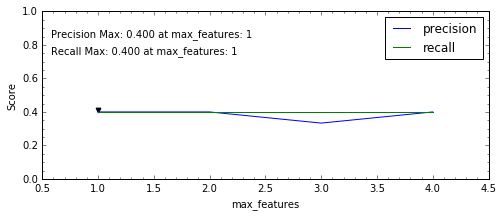

In [42]:
plot_precision_recall_param(prec, rec, feats, "max_features")

I'm going with max_features=4

In [43]:
depths = np.arange(1, 100)
prec = np.zeros(len(depths))
rec = np.zeros(len(depths))

for ii in range(len(depths)):
    clf = DecisionTreeClassifier(splitter="random", max_features=4,  
                                 max_depth=depths[ii], random_state=5,
                                criterion="entropy")
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")
 

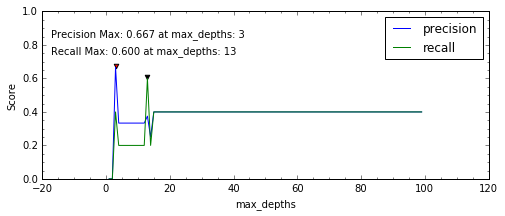

In [44]:
plot_precision_recall_param(prec, rec, depths, "max_depths")

Let's stick with a max depth of 20

In [45]:
min_samples = np.arange(2, 100)
prec = np.zeros(len(min_samples))
rec = np.zeros(len(min_samples))

for ii in range(len(min_samples)):
    clf = DecisionTreeClassifier(splitter="random", max_features=4, 
                                 max_depth=20, random_state=5, 
                                 criterion="entropy",
                                 min_samples_split=min_samples[ii])
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")
 

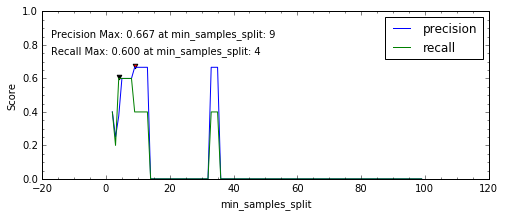

In [46]:
plot_precision_recall_param(prec, rec, min_samples, "min_samples_split")

min_samples_split=5

In [47]:
min_samples = np.arange(1, 100)
prec = np.zeros(len(min_samples))
rec = np.zeros(len(min_samples))

for ii in range(len(min_samples)):
    clf = DecisionTreeClassifier(splitter="random", max_features=4, 
                                 max_depth=20, random_state=5, 
                                 criterion="entropy", min_samples_split=5,
                                 min_samples_leaf=min_samples[ii])
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")
 

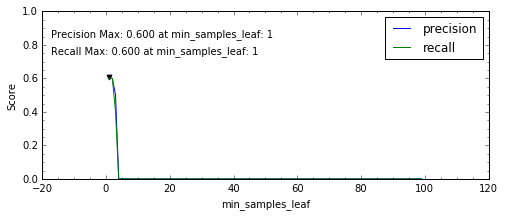

In [48]:
plot_precision_recall_param(prec, rec, min_samples, "min_samples_leaf")

Sticking with the default

In [49]:
classifiers["DecisionTree"] = DecisionTreeClassifier(splitter="random", max_features=4, 
                                 max_depth=20, random_state=5, 
                                 criterion="entropy", min_samples_split=5)

#### Tuning AdaBoostClassifier

In [50]:
n_estimators = np.arange(1, 200)
prec = np.zeros(len(n_estimators))
rec = np.zeros(len(n_estimators))

for ii in range(len(n_estimators)):
    clf = AdaBoostClassifier(n_estimators=n_estimators[ii], learning_rate=2.2)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")
 

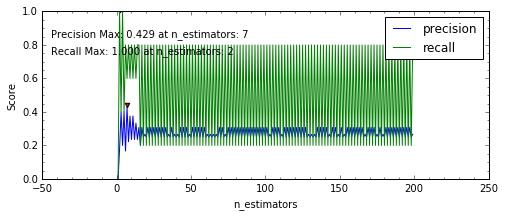

In [51]:
plot_precision_recall_param(prec, rec, n_estimators, "n_estimators")

In [52]:
learning_rate = np.linspace(0.01, 3, 100)
prec = np.zeros(len(learning_rate))
rec = np.zeros(len(learning_rate))

for ii in range(len(learning_rate)):
    clf = AdaBoostClassifier(learning_rate=learning_rate[ii], 
                             n_estimators=7)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")


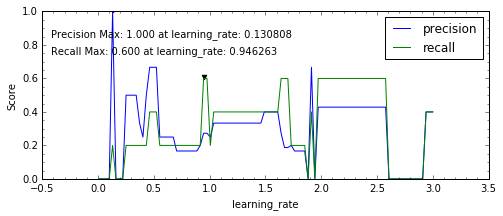

In [53]:
plot_precision_recall_param(prec, rec, learning_rate, "learning_rate")

optimal learning rate changes with n_estimators. n_estimators=7, learning_rate=1.55

In [54]:
classifiers["AdaBoost"] = AdaBoostClassifier(n_estimators=7, learning_rate=1.55)

### Tuning LinearSVC

In [55]:
C_vals = np.logspace(-2, 2, 100)
prec = np.zeros(len(C_vals))
rec = np.zeros(len(C_vals))

for ii in range(len(C_vals)):
    clf = LinearSVC(C = C_vals[ii], random_state=5)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")

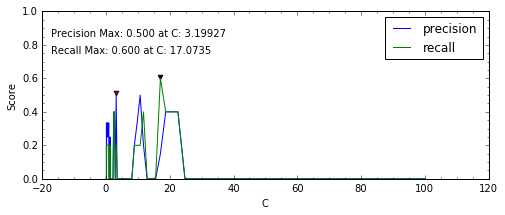

In [56]:
plot_precision_recall_param(prec, rec, C_vals, "C")

C = 20

In [57]:
clf = LinearSVC(C=20, loss="hinge", random_state=5)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")

Precision Score: 0.250
Recall Score: 0.200


In [58]:
clf = LinearSVC(C=20, loss="squared_hinge", random_state=5)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")

Precision Score: 0.400
Recall Score: 0.400


In [59]:
clf = LinearSVC(C=20, loss="squared_hinge", random_state=5, dual=True)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")

Precision Score: 0.400
Recall Score: 0.400


In [60]:
clf = LinearSVC(C=20, loss="squared_hinge", random_state=5, dual=False)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")

Precision Score: 0.000
Recall Score: 0.000


In [61]:
clf = LinearSVC(C=20, loss="squared_hinge", random_state=5, dual=True, fit_intercept=False)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")

Precision Score: 0.100
Recall Score: 0.200


In [62]:
clf = LinearSVC(C=20, loss="squared_hinge", random_state=5, dual=True, fit_intercept=True)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")

Precision Score: 0.400
Recall Score: 0.400


In [63]:
tol_array = np.logspace(-6, 0, 1000)
prec = np.zeros(len(tol_array))
rec = np.zeros(len(tol_array))

for ii in range(len(tol_array)):
    clf = LinearSVC(C=20, loss="squared_hinge", random_state=5, dual=True, 
                    fit_intercept=True, tol=tol_array[ii])
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")

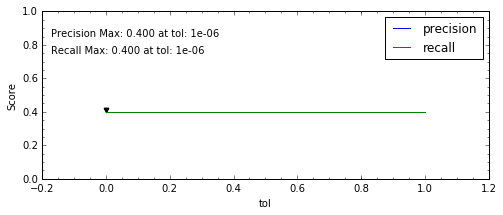

In [64]:
plot_precision_recall_param(prec, rec, tol_array, "tol")

In [65]:
classifiers["LinearSVC"] = LinearSVC(C=20, loss="squared_hinge", random_state=5, dual=True, 
                    fit_intercept=True)

### Tuning GradientBoosting

In [66]:
clf = GradientBoostingClassifier(loss="deviance", warm_start=True)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")


Precision Score: 0.500
Recall Score: 0.200


In [67]:
clf = GradientBoostingClassifier(loss="exponential", warm_start=True)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")


Precision Score: 0.667
Recall Score: 0.400


no difference at all.

In [68]:
learn = np.linspace(1, 35, 500)
prec = np.zeros(len(learn))
rec = np.zeros(len(learn))

for ii in range(len(learn)):
    clf = GradientBoostingClassifier(learning_rate=learn[ii], warm_start=True)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")

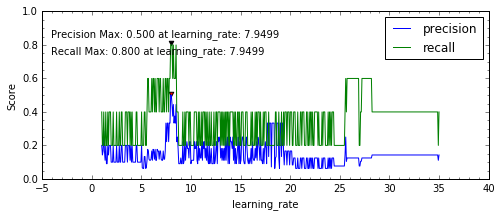

In [69]:
plot_precision_recall_param(prec, rec, learn, "learning_rate")

learning_rate = 10

In [70]:
estimators = np.arange(1, 50)
prec = np.zeros(len(estimators))
rec = np.zeros(len(estimators))

for ii in range(len(estimators)):
    clf = GradientBoostingClassifier(learning_rate=8., n_estimators=estimators[ii], warm_start=True)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")


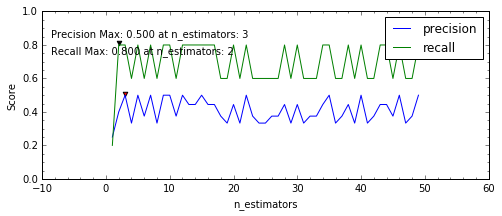

In [71]:
plot_precision_recall_param(prec, rec, estimators, "n_estimators")

n_estimators=5

In [72]:
depths = np.arange(1, 50)
prec = np.zeros(len(depths))
rec = np.zeros(len(depths))

for ii in range(len(depths)):
    clf = GradientBoostingClassifier(learning_rate=8., n_estimators=5, 
                                     max_depth=depths[ii], warm_start=True)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")


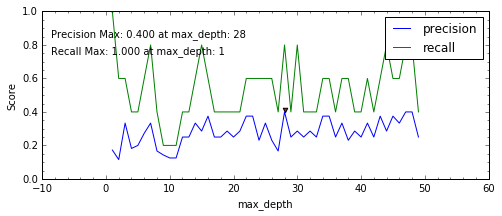

In [73]:
plot_precision_recall_param(prec, rec, depths, "max_depth")

max_depth=11

In [74]:
splits = np.arange(2, 50)
prec = np.zeros(len(splits))
rec = np.zeros(len(splits))

for ii in range(len(splits)):
    clf = GradientBoostingClassifier(learning_rate=8., n_estimators=5, max_depth=11,
                                     min_samples_split=splits[ii], warm_start=True)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")


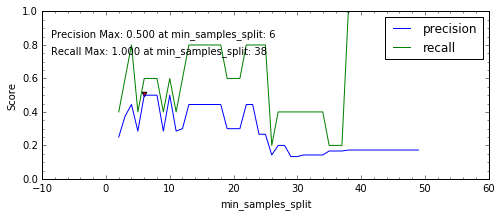

In [75]:
plot_precision_recall_param(prec, rec, splits, "min_samples_split")

In [76]:
samples = np.arange(2, 50)
prec = np.zeros(len(samples))
rec = np.zeros(len(samples))

for ii in range(len(samples)):
    clf = GradientBoostingClassifier(learning_rate=8., n_estimators=5, max_depth=11,
                                     min_samples_split=14, warm_start=True, 
                                     min_samples_leaf=samples[ii])
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")


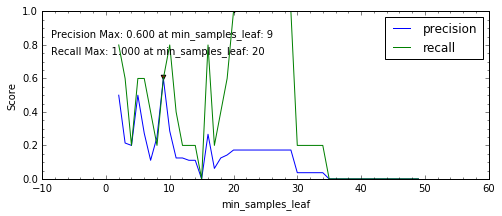

In [77]:
plot_precision_recall_param(prec, rec, samples, "min_samples_leaf")

min_samples_leaf = 9

In [78]:
samples = np.linspace(0.7, 1.0, 50)
prec = np.zeros(len(samples))
rec = np.zeros(len(samples))

for ii in range(len(samples)):
    clf = GradientBoostingClassifier(learning_rate=8., n_estimators=5, max_depth=11,
                                     min_samples_split=14, warm_start=True, 
                                     min_samples_leaf=9, subsample=samples[ii])
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")


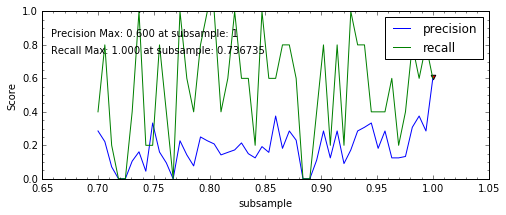

In [79]:
plot_precision_recall_param(prec, rec, samples, "subsample")

subsample=1.0

In [80]:
feats = np.arange(1, len(features_list))
prec = np.zeros(len(feats))
rec = np.zeros(len(feats))

for ii in range(len(feats)):
    clf = GradientBoostingClassifier(learning_rate=8., n_estimators=5, max_depth=11,
                                     min_samples_split=14, warm_start=True, 
                                     min_samples_leaf=9, max_features=feats[ii])
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")


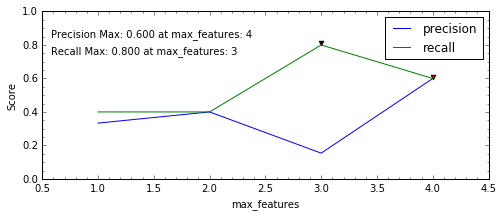

In [81]:
plot_precision_recall_param(prec, rec, feats, "max_features")

max_features=4.0

In [82]:
classifiers["GradientBoostingClassifier"] = GradientBoostingClassifier(learning_rate=8., 
                                                                       n_estimators=5, 
                                                                       max_depth=11, 
                                                                       min_samples_split=14, 
                                                                       warm_start=True,  
                                                                       min_samples_leaf=9, 
                                                                       max_features=4)

## Tuning RandomForest

In [83]:
clf = RandomForestClassifier(criterion="entropy", warm_start=True)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")


Precision Score: 0.000
Recall Score: 0.000


In [84]:
clf = RandomForestClassifier(criterion="gini", warm_start=True)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print "Precision Score: %.3f" % precision_score(y_test, pred, average="binary")
print "Recall Score: %.3f" % recall_score(y_test, pred, average="binary")


Precision Score: 0.500
Recall Score: 0.200


In [85]:
estimators = np.arange(1, 50)
prec = np.zeros(len(estimators))
rec = np.zeros(len(estimators))

for ii in range(len(estimators)):
    clf = RandomForestClassifier(n_estimators=estimators[ii], warm_start=True)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")


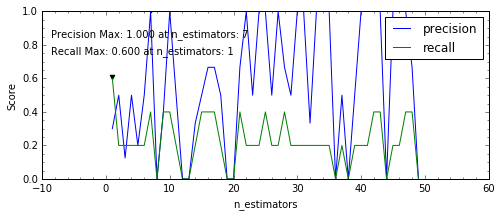

In [86]:
plot_precision_recall_param(prec, rec, estimators, "n_estimators")

n_estimators=18

In [87]:
feats = np.arange(1, len(features_list))
prec = np.zeros(len(feats))
rec = np.zeros(len(feats))

for ii in range(len(feats)):
    clf = RandomForestClassifier(n_estimators=18, max_features=feats[ii], warm_start=True)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")


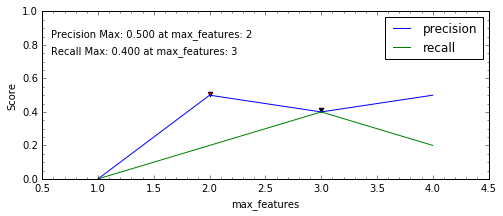

In [88]:
plot_precision_recall_param(prec, rec, feats, "max_features")

In [89]:
depths = np.arange(1, 50)
prec = np.zeros(len(depths))
rec = np.zeros(len(depths))

for ii in range(len(depths)):
    clf = RandomForestClassifier(n_estimators=18, max_features=2,
                                 max_depth=depths[ii], warm_start=True)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")


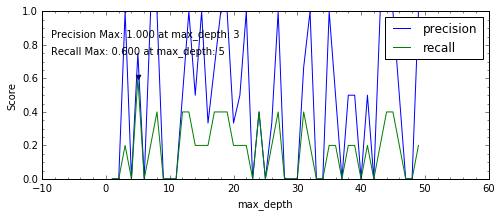

In [90]:
plot_precision_recall_param(prec, rec, depths, "max_depth")

max_depth=7

In [91]:
splits = np.arange(2, 50)
prec = np.zeros(len(splits))
rec = np.zeros(len(splits))

for ii in range(len(splits)):
    clf = RandomForestClassifier(n_estimators=18, max_features=2,
                                 max_depth=7, warm_start=True, min_samples_split=splits[ii])
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")


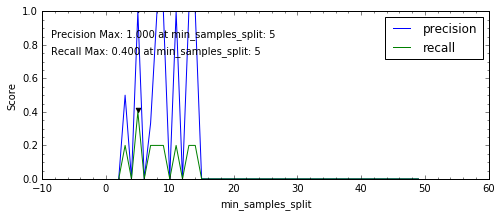

In [92]:
plot_precision_recall_param(prec, rec, splits, "min_samples_split")

In [93]:
samples = np.arange(1, 50)
prec = np.zeros(len(samples))
rec = np.zeros(len(samples))

for ii in range(len(samples)):
    clf = RandomForestClassifier(n_estimators=18, max_features=2,
                                 max_depth=7, warm_start=True, min_samples_leaf=samples[ii])
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    prec[ii] = precision_score(y_test, pred, average="binary")
    rec[ii] = recall_score(y_test, pred, average="binary")


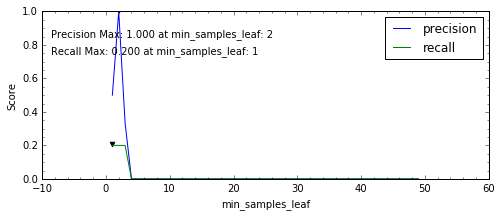

In [94]:
plot_precision_recall_param(prec, rec, samples, "min_samples_leaf")

In [95]:
classifiers["RandomForestClassifier"] = RandomForestClassifier(n_estimators=18, max_features=2,
                                 max_depth=7, warm_start=True)

/Users/Nick/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:267: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


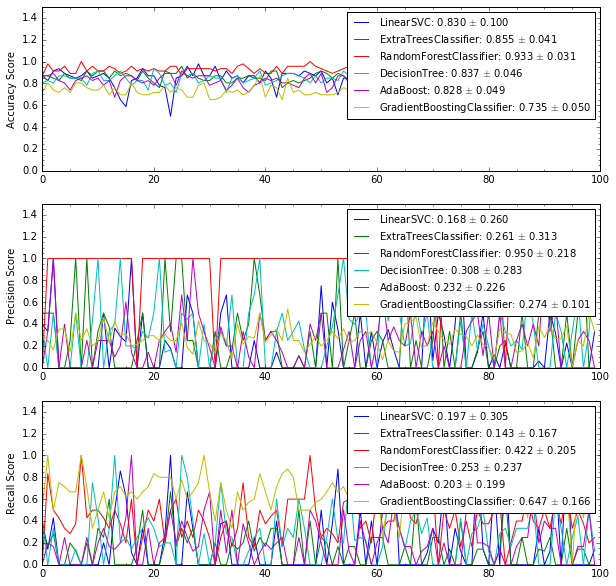

In [96]:
evaluate_classifiers(classifiers, features, labels, prec_avg="binary", 
                     plot=True, iters=100, outfile="classifier_eval.png")

In [97]:
for cla in classifiers.keys():
    print classifiers[cla]

LinearSVC(C=20, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=5, tol=0.0001,
     verbose=0)
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=2, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=2, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=True)
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
            max_features=4, max_leaf_node

**GaussianNB** is marginal. The variance is large enough where, depending on the random state set for cross-validation, it may or may not pass. 

**KMeans** is spectacular in precision, but just under (most of the time) in recall. It also may or may not pass.

**AdaBoostClassifier** is good in precision, not *quite* as good in recall, but the best of the worst aside from GaussianNB

**BaggingClassifier** can work!

**LinearSVC** is always failing, with a large variance that dips above and below our threshhold of 0.3. 

**DecisionTreeClassifier** is *heavily* dependent on the test sample and the random state, with a standard deviation on the order of its mean. It's not reliable in this context. 

**GMM** is garbage

In [98]:
the_query = "SELECT employee FROM data_df"
the_query += " WHERE employee NOT IN (SELECT employee FROM no_outliers)"
removed = sql.sqldf(the_query, locals())
removed.to_csv("removed_employees.txt", index=False, header=False)